# This notebook is dedicated to find the best parameters and feature selection process 

In [1]:
import numpy as np
import mat73
import pandas as pd
from hyperopt import tpe
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.signal import filtfilt,butter,hilbert,convolve2d,convolve
import scipy.io as sio
from Bolu_IFG.utils import get_train_test,decoding,reformat
import nltk
from nltk.stem import WordNetLemmatizer
import hyperopt
import collections
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from multiprocessing import Pool

# Download the CMU Pronouncing Dictionary
nltk.download('cmudict')
# Create a sentence to phoneme dictionary
words_to_phonemes = nltk.corpus.cmudict.dict()

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [2]:
band='spike_band' ## this could be high gamma band or spike band

date = 'Jan05_2024'  # here we have Jan05_2024,
data_path = f'../Bolu_IFG/processed_data/{band}_power/{date}_all_blocks.mat'

try:
    raw_data_jan = pd.DataFrame(sio.loadmat(data_path)['all_data'])
except:
    raw_data_jan = pd.DataFrame(mat73.loadmat(data_path)['all_data'])
date = 'Dec06_2023'  # here we have Jan05_2024, Dec06_2023 data
data_path = f'../Bolu_IFG/processed_data/{band}_power/{date}_all_blocks.mat'

try:
    raw_data_dec = pd.DataFrame(sio.loadmat(data_path)['all_data'])
except:
    raw_data_dec = pd.DataFrame(mat73.loadmat(data_path)['all_data'])

In [3]:
# concatenate data
raw_data=pd.concat([raw_data_dec,raw_data_jan])
all_data=raw_data[1].to_list()

rejected_channels: [ 3 62] 

rejected_trials: [ 32  64  65  91 103 108 109 110 111 112 130 246 281]


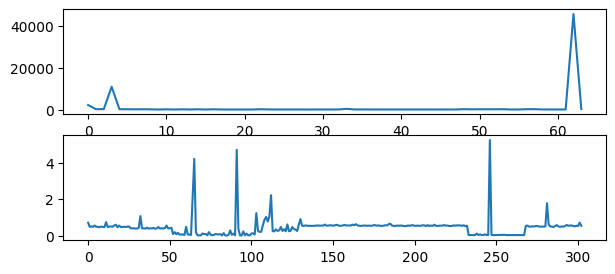

In [4]:
# concatenate data
raw_data = pd.concat([raw_data_jan,raw_data_dec])

## throw away the bad trials: only used in Jan data
## hard coded here
#bad_trials=[27,30,34,50,53,55,56,58,60,62,65,66,67,68,69,83,85,94]
#raw_data=raw_data.drop(raw_data.index[bad_trials])
all_data = raw_data[1].to_list()
## channel cleaning
channel_std=raw_data[0].to_list()[0]
channel_std_std=channel_std.std()
reject_channels=np.where(channel_std>channel_std.std())[0]
channel_clean_data=[np.delete(a,reject_channels,axis=0) for a in all_data]
### trial cleaning
trial_std=np.array([t.mean(axis=0).std() for t in channel_clean_data])
reject_trials=np.where(trial_std>1.5*trial_std.std())[0]
# a bit too complicate but i don't know any better method so far

raw_data=raw_data.drop(raw_data.index[reject_trials])
clean_data=[np.delete(a,reject_channels,axis=0) for a in raw_data[1].to_list()]
print(f"rejected_channels: {reject_channels} \n")
print(f"rejected_trials: {reject_trials}")

fig,ax=plt.subplots(2,1,figsize=(7,3))
ax[0].plot(channel_std)
ax[1].plot(trial_std)
plt.show()

In [5]:
# process the labels
correct_label = raw_data[10].to_numpy()
answered_label = raw_data[11].to_numpy()
answered_words = raw_data[8].to_numpy()
#answered_semantic_label=raw_data[12].to_numpy()
correct_label = np.array([a[0] for a in correct_label])
answered_label = np.array([a[0] for a in answered_label])
#answered_semantic_label=np.array([a[0] if a!=np.NaN else np.NaN for a in answered_semantic_label])
lemmatizer = WordNetLemmatizer()
answered_lexical_item = np.array([lemmatizer.lemmatize(a[0][0][0], pos='v') for a in answered_words])
first_phonemes = np.array([words_to_phonemes[a][0][0] for a in answered_lexical_item])

# process the time stamps
phrase_on = raw_data[2].to_numpy()
word_on = raw_data[4].to_numpy()
voice_on = raw_data[6].to_numpy()
voice_off = raw_data[7].to_numpy()

phrase_on = np.array([a[0][0] for a in phrase_on])
word_on = np.array([a[0][0] for a in word_on])
voice_on = np.array([a[0][0] for a in voice_on])
voice_off = np.array([a[0][0] for a in voice_off])

# recording frequency rate
fs = 2000
print(collections.Counter(answered_lexical_item))
#print(collections.Counter(answered_semantic_label))
print(collections.Counter(first_phonemes))
print(collections.Counter(answered_label))

Counter({'rub': 22, 'tip': 22, 'bake': 16, 'pack': 15, 'keep': 14, 'boot': 14, 'date': 13, 'call': 12, 'pass': 12, 'talk': 12, 'dock': 11, 'rap': 11, 'cry': 7, 'run': 6, 'chew': 5, 'fail': 5, 'snore': 5, 'look': 5, 'grab': 5, 'wipe': 5, 'jump': 4, 'kick': 4, 'need': 4, 'vote': 4, 'lick': 4, 'star': 3, 'yell': 3, 'cut': 3, 'heal': 3, 'bite': 3, 'peek': 3, 'mix': 3, 'chase': 3, 'stare': 3, 'kiss': 3, 'punch': 2, 'see': 2, 'write': 2, 'hop': 2, 'load': 1, 'walk': 1, 'type': 1})
Counter({'K': 43, 'R': 41, 'T': 35, 'B': 33, 'P': 32, 'D': 24, 'S': 13, 'L': 10, 'CH': 8, 'W': 6, 'F': 5, 'HH': 5, 'G': 5, 'JH': 4, 'N': 4, 'V': 4, 'Y': 3, 'M': 3})
Counter({'2': 135, '1': 79, '3': 64})


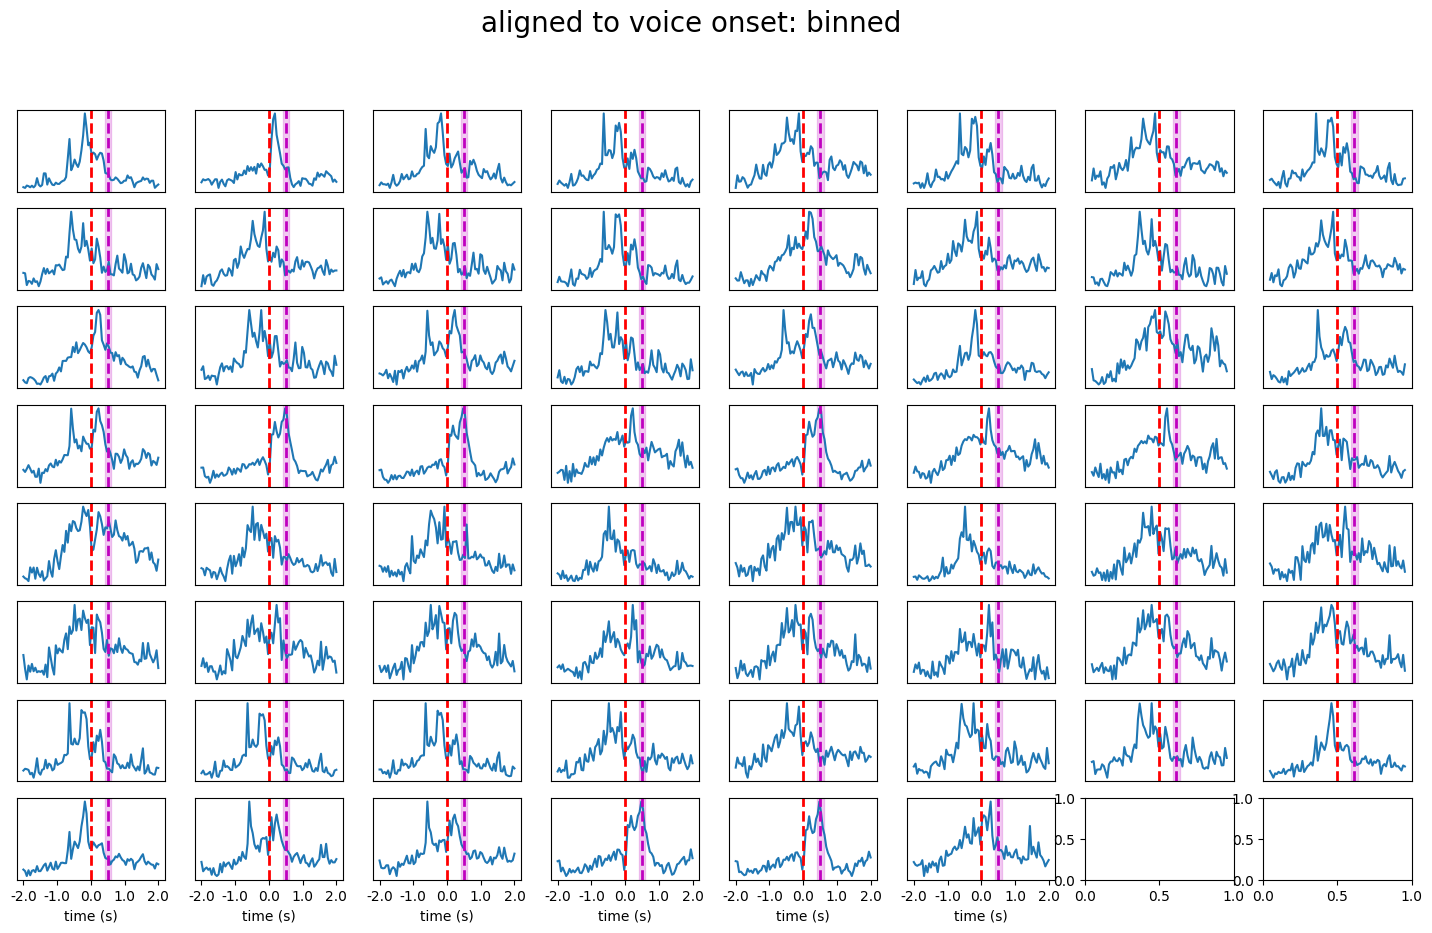

In [7]:
# define the decoding time range and bin the data
# aligning to the voice onset

back=2 # looking back 3 seconds before onset
forward=2 # looking forward 1 second after onset
bin_size=0.05 # s
adjusted_fs=1/bin_size # Hz
processed_data_voice_on=[trial[:,int(voice_on[i]*fs-back*fs) : int(voice_on[i]*fs+forward*fs)] for i,trial in enumerate(clean_data)]
n_channels=processed_data_voice_on[0].shape[0]
n_trials_total=len(processed_data_voice_on)
binned_data_voice_on=[trial.reshape(n_channels,int(bin_size*fs),-1,order='F').mean(axis=1) for trial in processed_data_voice_on]
binned_data_voice_on_averaged=np.mean(binned_data_voice_on,axis=0)
n_bins=binned_data_voice_on_averaged.shape[-1]

ave_voice_on=back

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(n_channels):
    ax[i//8,i%8].plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,(back+forward)*adjusted_fs,5), [f"{i:0.1f}" for i in np.linspace(-back,forward,5)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * adjusted_fs - std_word_on * adjusted_fs, ave_word_on * adjusted_fs + std_word_on * adjusted_fs, color='g', alpha=0.2)
    #ax[i//8,i%8].axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset: binned",fontsize=20)
plt.show()

In [8]:
# # build a decoder using PCs and multiple bins
# # build decoder for each bin
# 
# #### syntax labels
# data_to_use=np.swapaxes(np.array(binned_data_voice_on)[answered_label!='1',:,:],1,2)
# labels_to_use=answered_label[answered_label!='1']
# 
# #### lexical labels
# # data_to_use=np.swapaxes(np.array(binned_data_voice_on)[(answered_lexical_item=='run')|(answered_lexical_item=='chew'),:,:],1,2)
# # labels_to_use=answered_lexical_item[(answered_lexical_item=='run')|(answered_lexical_item=='chew')]
# 
# #### semantic labels
# # criteria=(answered_semantic_label=='a')|(answered_semantic_label=='e')
# # data_to_use=np.swapaxes(np.array(binned_data_voice_on)[:,:,:],1,2)
# # labels_to_use=answered_semantic_label[:]
# 
# 
# #### first phoneme labels
# # criteria=(first_phonemes=='R')|(first_phonemes=='CH')
# # data_to_use=np.swapaxes(np.array(binned_data_voice_on)[criteria,:,:],1,2)
# # labels_to_use=first_phonemes[criteria]
# 
# 
# # define how many bins we want in each feature
# n_bins_per_feature=15
# ## perform PCA
# n_PC=6
# pca=PCA(n_components=n_PC)
# pca.fit(data_to_use.reshape(-1,n_channels))
# reduced_data=(pca.transform(data_to_use.reshape(-1,n_channels))/pca.singular_values_).reshape(-1,n_bins,n_PC)
# 
# # reformat the data
# X_=reformat(reduced_data,n_bins_per_feature) # data is a list
# 
# ### start decoding
# decoder=SVC(C=10**3.11,kernel='rbf',gamma=10**-1.2,probability=False)
# #decoder=SVC()
# #decoder=LinearSVC()
# averaged_accuracy=[]
# averaged_chance=[]
# for j in range(100):
#     accuracy=[]
#     chance=[]
#     for n_bin in range(len(X_)):
#         X_train, X_test, y_train, y_test =get_train_test(X_[n_bin],labels_to_use,train=0.8)
#         if X_train.shape[1] !=0:
#             decoder.fit(X_train, y_train)
#             y_predict=decoder.predict(X_test)
#             correct=np.sum(y_predict==y_test)
#             accuracy.append(correct/len(y_predict))
#                      
#             np.random.shuffle(X_train.T)
#             np.random.shuffle(y_train)
#             decoder.fit(X_train, y_train)
#             y_predict=decoder.predict(X_test)
#             correct=np.sum(y_predict==y_test)
#             chance.append(correct/len(y_predict))
#         else:
#             accuracy.append(np.NaN)
#             chance.append(np.NaN)
#         
#     averaged_accuracy.append(accuracy)
#     averaged_chance.append(chance)


In [9]:
# fig,ax=plt.subplots(1,1,)
# ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
#                 np.mean(averaged_accuracy,axis=0)-np.std(averaged_accuracy,axis=0),
#                np.mean(averaged_accuracy,axis=0)+np.std(averaged_accuracy,axis=0),alpha=0.2)
# ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_accuracy,axis=0),lw=3)
# ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_chance,axis=0),lw=2,linestyle='--',color='orange')
# ax2=ax.twinx()
# ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged.mean(axis=0),c='grey',linestyle='--')
# ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
#     
# ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
# ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
# ax.set_xticks(np.linspace(0,len(accuracy),7), [f"{i:0.1f}" for i in np.linspace(-back,forward,7)])
# ax.set_ylim([0.4,1])
# ax.set_xlabel("time (s)")
# ax.set_ylabel("accuracy")
# ax2.set_ylabel("zscored activity (a.u.)")
# plt.show()

In [10]:
# # here we look at the VAF of PCA
# plt.plot(np.linspace(1,n_PC,n_PC),np.cumsum(pca.explained_variance_ratio_))
# plt.show()

# Here we are trying to tune the hyper parameters
### things to tune
- decoder
- nPCs
- n_bins
### note that we are not tuning the SVC kernel yet

In [11]:
def objective(variables):
    n_PC, n_bins_per_feature,C,gamma=variables
    n_PC=int(n_PC)
    #print(n_PC)
    decoder=SVC(kernel='rbf',C=10**C,gamma=10**gamma,class_weight='balanced')

    
    extractor=PCA(n_components=n_PC)
    X_to_use=reformat(data_to_use,n_bins_per_feature+1)
    
    # get accuracy for all bins
    all_accuracy=[]
    for n_bin in range(len(X_to_use)):
        X_train_test_to_use=np.delete(X_to_use[n_bin],val_index,axis=0)
        Y_train_test_to_use=np.delete(labels_to_use, val_index)
        
        # loop between train-test split
        accuracy=[]
        for i, (train_index, test_index) in enumerate(skf.split(X_train_test_to_use, Y_train_test_to_use)):
            # get the train/test
            X_train=X_train_test_to_use[train_index]
            X_test=X_train_test_to_use[test_index]
            # get the labels
            y_train=Y_train_test_to_use[train_index]
            y_test=Y_train_test_to_use[test_index]
            
            # extract the features
            extractor.fit(X_train)
            X_train_low=extractor.transform(X_train)
            X_test_low=extractor.transform(X_test)
            
            # classification 
            decoder.fit(X_train_low, y_train)
            y_predict=decoder.predict(X_test_low)
            
            # calculate the accuracy
            correct=np.sum(y_predict==y_test)
            accuracy.append(correct/len(y_predict))
            
        all_accuracy.append(accuracy)
    max_mean_accuracy=np.mean(np.array(all_accuracy),axis=1).max()
    # penalize large value of n_PC and n_bins_per_feature
    return {'loss':-max_mean_accuracy,'status': hyperopt.STATUS_OK}

In [13]:
from sklearn.model_selection import StratifiedKFold


############# prepare the data ###############################
data_to_use=np.swapaxes(np.array(binned_data_voice_on)[answered_label!='1',:,:],1,2)
labels_to_use=answered_label[answered_label!='1']
 
# Define the number of epochs to run
n_epoch=5
n_max_iter=500
# for Jan data we have 130 trials, resulting in 117 train-test set. 5 folds will be will in 94 train and 23 test samples.
skf=StratifiedKFold(n_splits=5) 

# get the train-test, val set ready
all_val_index=[np.random.choice(len(labels_to_use),int(len(labels_to_use)*0.1),replace=False) for _ in range(n_epoch)]

# stor everything in Trial
all_trials=[]
all_best=[]
all_val_accuracy=[]
all_chance=[]
# for each epoch:
for epoch in range(n_epoch):
    print(f"start epoch {epoch+1}\n")
    val_index=np.array(all_val_index[epoch]) 
    n_PC_space=hyperopt.hp.quniform("n_PC",2,50,1) # this equivalent to E=1075, Var=101. for the lognormal distribution
    n_bins_per_feature_space=hyperopt.hp.randint("n_bins_per_feature",20) # 20 bins maximum
    C=hyperopt.hp.normal("C",0,1)
    gamma=hyperopt.hp.normal("gamma",0,1)
    
    trials=hyperopt.Trials()
    best=hyperopt.fmin(objective,
                       space=[n_PC_space,
                              n_bins_per_feature_space,
                              C,
                              gamma
                              ],
                       algo=hyperopt.tpe.suggest,max_evals=n_max_iter,trials=trials,
                       )
    ### after finding the best, test it on the validation set
    # here come the star hyperparameter ^_^

    n_PC=int(best['n_PC'])
    n_bins_per_feature = best['n_bins_per_feature']
    decoder=SVC(kernel='rbf',C=10**best['C'],gamma=10**best['gamma'])
    
    extractor=PCA(n_components=n_PC)
    X_to_use=reformat(data_to_use,n_bins_per_feature+1)
    
    accuracy=[]
    chance=[]
    for n_bin in range(len(X_to_use)):
        X_train_all=np.delete(X_to_use[n_bin],val_index,axis=0)
        Y_train_all=np.delete(labels_to_use, val_index)
        X_val=X_to_use[n_bin][val_index]
        Y_val=labels_to_use[val_index]
        
        extractor.fit(X_val)
        X_val_low= extractor.transform(X_val)
        X_test_low=extractor.transform(X_val)
    
        decoder.fit(X_val_low, Y_val)
        y_predict=decoder.predict(X_val_low)
        correct=np.sum(y_predict==Y_val)
        accuracy.append(correct/len(y_predict))
        
        np.random.shuffle(X_val_low)      
        decoder.fit(X_val_low, Y_val)
        y_predict=decoder.predict(X_val)
        correct=np.sum(y_predict==Y_val)
        chance.append(correct/len(y_predict))
           
    all_val_accuracy.append(accuracy)
    all_chance.append(chance)  
    all_trials.append(trials)
    all_best.append(best)


start epoch 1

100%|██████████| 500/500 [14:03:11<00:00, 101.18s/trial, best loss: -0.7944444444444444]   


ValueError: n_components=32 must be between 0 and min(n_samples, n_features)=19 with svd_solver='full'

In [ ]:
fig,ax=plt.subplots(1,1,)
ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
                np.mean(all_val_accuracy,axis=0)-np.std(all_val_accuracy,axis=0),
               np.mean(all_val_accuracy,axis=0)+np.std(all_val_accuracy,axis=0),alpha=0.2)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(all_val_accuracy,axis=0),lw=3)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(all_chance,axis=0),lw=2,linestyle='--',color='orange')
ax2=ax.twinx()
ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged.mean(axis=0),c='grey',linestyle='--')
ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
    
ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
 
ax.set_xticks(np.linspace(0,len(accuracy),7), [f"{i:0.1f}" for i in np.linspace(-back,forward,7)])
ax.set_xlabel("time (s)")
ax.set_ylabel("accuracy")
ax2.set_ylabel("zscored activity (a.u.)")
plt.show()

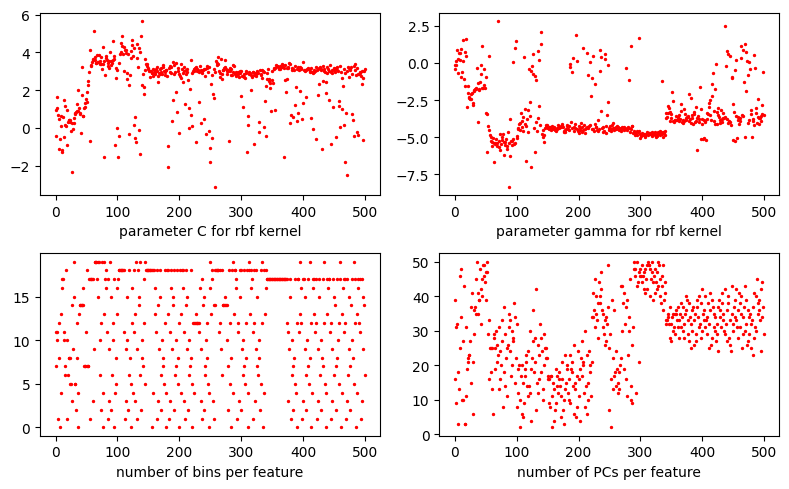

In [14]:
# visualize the trials
fig,ax=plt.subplots(2,2,figsize=(8,5))
colors=['r','g','b','c','m','y','k']
#for i,trial in enumerate(all_trials):
index_trial=trials.idxs_vals[0]['C']
C_trial=trials.idxs_vals[1]['C']
gamma_trial=trials.idxs_vals[1]['gamma']
n_bins_per_feature_trial=trials.idxs_vals[1]['n_bins_per_feature']
n_PC_trial=trials.idxs_vals[1]['n_PC']

ax[0][0].scatter(index_trial,C_trial,s=2,c=colors[0])
ax[0][0].set_xlabel("parameter C for rbf kernel")
ax[0][1].scatter(index_trial,gamma_trial,s=2,c=colors[0])
ax[0][1].set_xlabel("parameter gamma for rbf kernel")
ax[1][0].scatter(index_trial,n_bins_per_feature_trial,s=2,c=colors[0])
ax[1][0].set_xlabel("number of bins per feature")
ax[1][1].scatter(index_trial,n_PC_trial,s=2,c=colors[0])
ax[1][1].set_xlabel("number of PCs per feature")
plt.tight_layout()
plt.show()     